## Load and plot polygons

In [1]:
import geopandas as gpd
import xarray as xr
import utm
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import glob
import shutil

# Load poylgons
shapes = '/home/cassandra/Snohomish/2025-11/Snohomish_combined.geojson'
gdf = gpd.read_file(shapes)
gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:32610')

include_poly  = gdf['geometry'][0:1]
bound_poly    = gdf['geometry'][1:2]
channel_polys = gdf['geometry'][2:23]

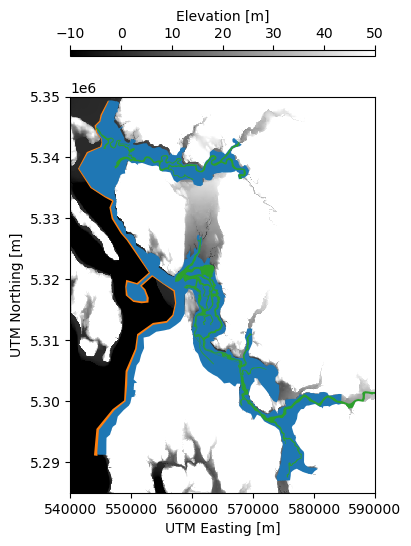

In [46]:
# Load low res DEM for plotting
dem = xr.open_dataset('/home/cassandra/Snohomish/test_data/snohomish_DEM.tif')
lat, lon = dem.y.values, dem.x.values
x, _, _, __ = utm.from_latlon(np.nanmean(lat)*np.ones(len(lon)), lon)
_, y, _, __ = utm.from_latlon(lat, np.nanmean(lon)*np.ones(len(lat)))

# Plot
fig, ax = plt.subplots(figsize=(4,6), constrained_layout=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
m = plt.pcolormesh(x, y, dem.band_data[0], cmap='binary_r', vmin=-10, vmax=50)
for i, poly in enumerate([include_poly, bound_poly, channel_polys]):
    poly.plot(ax=ax, alpha=1.0, color=colors[i], figsize=fig.get_size_inches())
cb = plt.colorbar(m, aspect=50, location='top')
cb.ax.set_xlabel("Elevation [m]")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.xlim(540000, 590000)
plt.ylim(5285000, 5350000)
plt.show()

So we have the view of Snohomish county that we plan to model...

## Load Tide Model And Prepare To Input

In [32]:
dfm_tide_file = '/home/cassandra/Data/Snohomish_all.nc'
dfm_tides = xr.open_dataset(dfm_tide_file)
tide_t = dfm_tides.time.values
# Convert matlab datenum to datetime64
def matlab2datetime(matlab_datenum, round_to):
    t = pd.to_datetime(matlab_datenum - 719529, unit='D')
    # Solution isn't exact so this round cleans things up
    t_clean = t.round(freq=round_to)  # hour 'min',
    return t_clean
tide_t = matlab2datetime(tide_t, 'min').values.astype('datetime64[m]')
t0, tf = tide_t[0], tide_t[-1]
print('Tide Model Time Bounds:', t0, tf)

Tide Model Time Bounds: 1984-09-30T00:00 2015-10-01T23:50


In [33]:
# Get water level and convert to meters
tide_h = dfm_tides.WL_2016_2099.values / 100
# Convert lat, lon to utm
tide_x, tide_y, _, __ = utm.from_latlon(dfm_tides.lat.values, dfm_tides.lon.values)
# Make HydroMT SFINCS compatible DataArray
tide_da = xr.DataArray(tide_h.T,
                       coords={"time"     : tide_t,
                               "location" : np.arange(0, len(dfm_tides.sta_name.values), 1),
                               "name": ("location", dfm_tides.sta_name.values),
                               "x"   : ("location", tide_x),
                               "y"   : ("location", tide_y), },
                       dims=["time", "location"],
                       name="tide")
tide_da.to_netcdf('/home/cassandra/Snohomish/test_data/2025-11-tide.nc')

## Stream Gage Availability
For modeling previous water years, obviously direct observations of stream gage discharges is preferable. Let's see what's available... First, for each stream gage:

In [62]:
import dataretrieval.nwis as nwis

site_names = ['Monroe',     'Pilchuck',  'Snohomish',  'Duvall',    
              'Gold Bar',   'Wallace',   'Sultan',    'Quilceda', 
              'Carnation',  'Marysville','Stanwood', 'Arlington',
              'Deer Creek', 'Granite Falls', 'Arlington (2)']

site_nums  = ['12150800', '12155300',  '12155500',  '12150400',  
              '12134500', '12135000',  '12138160',  '12157005', 
              '12149000', '12157000',  '12170300',  '12167400',
              '12166500', '12161000',  '12167000']

In [64]:
sdf = nwis.get_record(sites=site_nums, service='site')
ddf = nwis.get_record(sites=site_nums, service='dv', start=str(t0.astype('datetime64[D]')), end=str(tf.astype('datetime64[D]')))

sdf.to_csv('/home/cassandra/Snohomish/test_data/2025-11-sdf.csv')
ddf.to_csv('/home/cassandra/Snohomish/test_data/2025-11-ddf.csv')

In [65]:
sdf = pd.read_csv('/home/cassandra/Snohomish/test_data/2025-11-sdf.csv')
ddf = pd.read_csv('/home/cassandra/Snohomish/test_data/2025-11-ddf.csv')

/tmp/ipykernel_187327/1696468435.py:2: DtypeWarning: Columns (7,9,11,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  ddf = pd.read_csv('/home/cassandra/Snohomish/test_data/2025-11-ddf.csv')


In [124]:
sites, time, discharge, stage = ddf['site_no'], ddf['datetime'], ddf['00060_Mean'], ddf['00065_Mean']

avail = []
for s,n in zip(site_nums, site_names):
    is_site = sites == int(s)
    avail.append(np.nansum(is_site))
avail = np.around(np.array(avail) / (tf-t0).astype('timedelta64[D]').astype(float), 2)

Duvall not plotted because it has less than 10% coverage
Quilceda not plotted because it has less than 10% coverage
Marysville not plotted because it has less than 10% coverage
Stanwood not plotted because it has less than 10% coverage
Arlington not plotted because it has less than 10% coverage
Deer Creek not plotted because it has less than 10% coverage
Granite Falls not plotted because it has less than 10% coverage


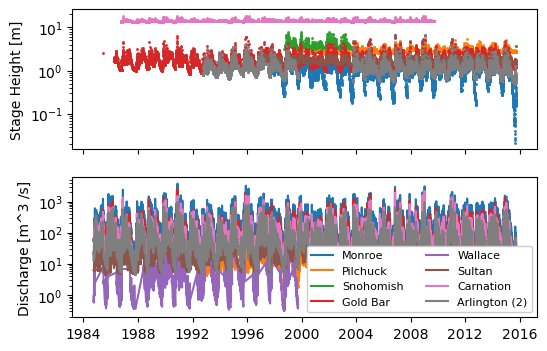

In [132]:
valid_sites = np.unique(ddf['site_no'].values)

mpf = 0.3048
cmpcf = mpf**3

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sites, time, discharge, stage = ddf['site_no'], ddf['datetime'], ddf['00060_Mean'], ddf['00065_Mean']
time = pd.to_datetime(time).values

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
for s,n,a in zip(site_nums, site_names, avail):
    if a < 0.1:
        print(n, 'not plotted because it has less than 10% coverage')
        continue
    # c = colors.pop(0)
    is_site = sites == int(s)
    axs[0].scatter(time[is_site], stage[is_site] * mpf, label=n, s=1) #, color=c)
    axs[1].plot(time[is_site], discharge[is_site] * cmpcf, label=n) #, color=c)
axs[0].set_ylabel("Stage Height [m]")
axs[1].set_ylabel("Discharge [m^3 /s]")
axs[1].legend(fontsize=8, framealpha=1, ncols=2)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.show()

Plot all the site locations for comparison

Duvall not plotted because it has less than 10% coverage
Quilceda not plotted because it has less than 10% coverage
Marysville not plotted because it has less than 10% coverage
Stanwood not plotted because it has less than 10% coverage
Arlington not plotted because it has less than 10% coverage
Deer Creek not plotted because it has less than 10% coverage
Granite Falls not plotted because it has less than 10% coverage


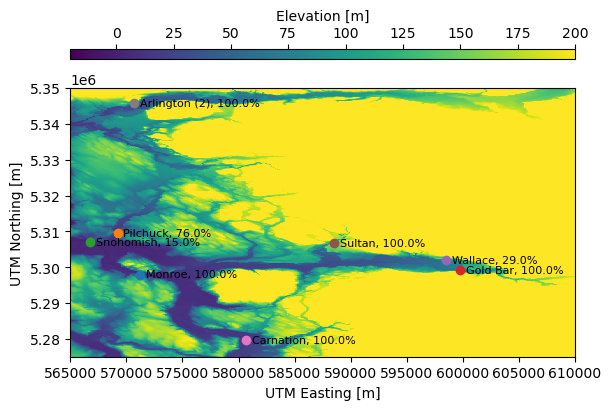

In [144]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
m = plt.pcolormesh(x, y, dem.band_data[0], vmin=-20, vmax=200)
for s,n,a in zip(site_nums, site_names, avail):
    is_site = sites == int(s)
    if a < 0.1:
        print(n, 'not plotted because it has less than 10% coverage')
        continue
    lat = sdf['dec_lat_va'][np.where(sdf['site_no'] == int(s))[0][0]]
    lon = sdf['dec_long_va'][np.where(sdf['site_no'] == int(s))[0][0]]
    ux, uy, _, __ = utm.from_latlon(lat, lon)
    plt.scatter(ux, uy, label=n)
    plt.text(ux + 500, uy, n + ', ' + str(np.around(100*a))+'%', fontsize=8, va='center')
cb = plt.colorbar(m, aspect=50, location='top')
cb.ax.set_xlabel("Elevation [m]")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
# plt.legend(ncols=2)
plt.xlim(565000, 610000)
plt.ylim(5275000, 5350000)
plt.show()

## Combine and Prepare Stream Gages

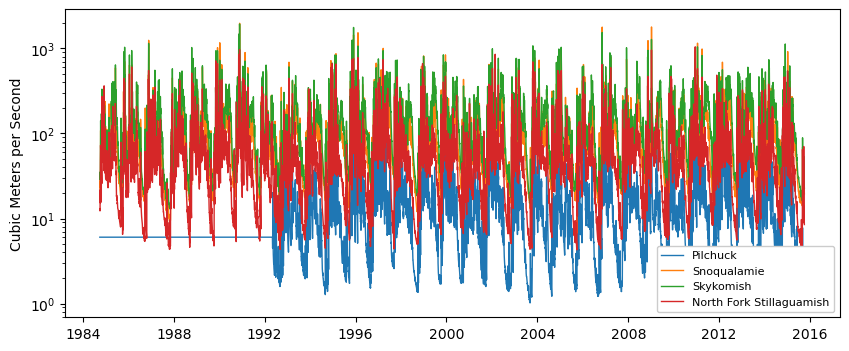

In [146]:
mpf = 0.3048
cmpcf = mpf**3

# Grid things on a shared time grid
t = np.arange(t0, tf, np.timedelta64(1, 'D'))
site_discharge = {}
site_latlon = {}
for s,n in zip(site_nums, site_names):
    lat = sdf['dec_lat_va'][np.where(sdf['site_no'] == int(s))[0][0]]
    lon = sdf['dec_long_va'][np.where(sdf['site_no'] == int(s))[0][0]]
    site_latlon.update({n: [lat,lon]})
    is_site = sites == int(s)
    if np.nansum(is_site) == 0:
        site_discharge.update({n:np.nan*np.ones(len(t))})
        continue
    site_discharge.update({n:np.interp(t.astype('datetime64[ms]').astype(float), 
                                       time[is_site].astype('datetime64[ms]').astype(float), 
                                       discharge[is_site]*cmpcf)})
# Access discharges
pilchuck  = site_discharge['Pilchuck']
duvall    = site_discharge['Carnation'] # Use Carnation because Duvall not available
goldbar   = site_discharge['Gold Bar']
sultan    = site_discharge['Sultan']
arlington = site_discharge['Arlington (2)']

# Adjust so Duvall + Goldbar + Sultan add up to Monroe at any given time
monroe_actual = site_discharge['Monroe']
monroe_sum    = duvall + goldbar + sultan
factor = monroe_actual / monroe_sum
duvall, goldbar = duvall*factor, (goldbar + sultan)*factor

# Get locations in UTM -- these correspond to the model boundaries...
p_x, p_y, _, __ = utm.from_latlon(47.94932162136976, -122.07039849849073)
d_x, d_y, _, __ = utm.from_latlon(47.737415804114505, -121.99136144412249)
g_x, g_y, _, __ = utm.from_latlon(47.84585868455693, -121.8729918400244)
a_x, a_y, _, __ = utm.from_latlon(48.230545813276876, -122.08833899797213)

# Make necessary arrays
station_names = ['Pilchuck', 'Snoqualamie', 'Skykomish', 'North Fork Stillaguamish']
station_discharge = np.array([pilchuck, duvall, goldbar, arlington]) 

# Create a DataArray
discharge_da = xr.DataArray(station_discharge.T,
                            coords={"time": t,
                                    "location": np.arange(0, len(station_names), 1),
                                    'name': ("location", station_names),
                                    "x"   : ("location", [p_x, d_x, g_x, a_x]),
                                    "y"   : ("location", [p_y, d_y, g_y, a_y]), },
                            dims=["time", "location"],
                            name="discharge")

discharge_da.to_netcdf('/home/cassandra/Snohomish/test_data/2025-11-discharge.nc')

plt.figure(figsize=(10,4))
for n,d in zip(station_names, station_discharge):
    plt.plot(t, d, label=n, linewidth=1)
plt.ylabel("Cubic Meters per Second")
plt.legend(loc=4, fontsize=8, framealpha=1)
plt.yscale('log')
plt.show()

## Stream Gage / Tide Location Sanity Check

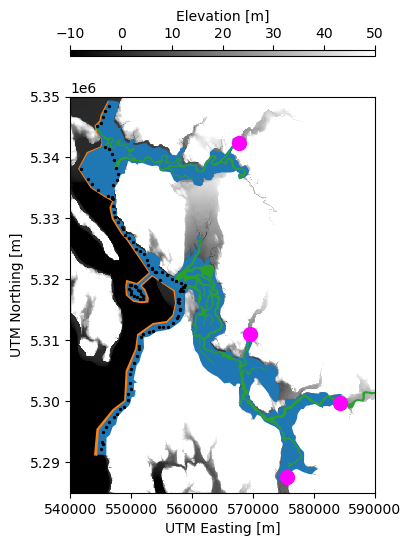

In [94]:
# Load low res DEM for plotting
dem = xr.open_dataset('/home/cassandra/Snohomish/test_data/snohomish_DEM.tif')
lat, lon = dem.y.values, dem.x.values
x, _, _, __ = utm.from_latlon(np.nanmean(lat)*np.ones(len(lon)), lon)
_, y, _, __ = utm.from_latlon(lat, np.nanmean(lon)*np.ones(len(lat)))

# Plot
fig, ax = plt.subplots(figsize=(4,6), constrained_layout=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
m = plt.pcolormesh(x, y, dem.band_data[0], cmap='binary_r', vmin=-10, vmax=50)
for i, poly in enumerate([include_poly, bound_poly, channel_polys]):
    poly.plot(ax=ax, alpha=1.0, color=colors[i], figsize=fig.get_size_inches())
plt.scatter([p_x, d_x, g_x, a_x], [p_y, d_y, g_y, a_y], color='magenta', s=100)
plt.scatter(tide_da.x.values, tide_da.y.values, color='black', s=2)
cb = plt.colorbar(m, aspect=50, location='top')
cb.ax.set_xlabel("Elevation [m]")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.xlim(540000, 590000)
plt.ylim(5285000, 5350000)
plt.show()

## Observation Points

In [150]:
ncs =  ["/home/cassandra/Data/validation_nc/AN1_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/EB1_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/EB2_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/EB3_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/EB4_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/EB5_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/EBF_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/FWF_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/JN1_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/MS1_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/MS2_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/MS3_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/QTG_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/QW1_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/SB1_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/SB2_waterlevel.nc",
        "/home/cassandra/Data/validation_nc/UN1_waterlevel.nc"]

points = []
for n in ncs:
    nc = xr.open_dataset(n)
    latitude = float(nc.site_longitude)
    longitude = float(nc.site_latitude)
    name = n[-17:-14]
    points.append({"type": "Feature",
                   "geometry": {"type": "Point", "coordinates": [longitude, latitude]},
                   "properties": {"name": name}})

# Create GeoJSON structure
geojson_feature_collection = {"type": "FeatureCollection", "features": points}
# Save to file
obs_points_file = '/home/cassandra/Snohomish/test_data/2025-11-obs.geojson'
with open(obs_points_file, "w") as f:
    json.dump(geojson_feature_collection, f, indent=4)

## Quadtree Build

In [1]:
from cht_sfincs import SFINCS
from cht_bathymetry import BathymetryDatabase
from hydromt_sfincs import SfincsModel
from pyproj import CRS
import geopandas as gpd
import xarray as xr
import utm
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import os

# Load poylgons
shapes = '/home/cassandra/Snohomish/2025-11/Snohomish_combined.geojson'
gdf = gpd.read_file(shapes)
gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:32610')

include_poly  = gpd.GeoDataFrame(geometry=gdf['geometry'][0:1])
bound_poly    = gpd.GeoDataFrame(geometry=gdf['geometry'][1:2])
channel_polys = gpd.GeoDataFrame(geometry=gdf['geometry'][2:23])

In [2]:
dem_path = '/home/cassandra/Data/Snoh_DEM_composite/Snohomish_MosaicDEM.tif'
man_path = '/home/cassandra/Snohomish/test_data/snohomish_manning.tif'

In [5]:
if not os.path.exists(quadtree_dir):
    os.mkdir(quadtree_dir)
if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)

In [3]:
quadtree_dir = '/home/cassandra/Snohomish/2025-11/'
parent_dir   = '/home/cassandra/Snohomish/2025-11/snohomish_30/'

In [4]:
# Some bound for the outer boundary of the grid
x_min, x_max = 540000, 590000
y_min, y_max = 5285000, 5350000

# Quadtree grid characteristics
dx, dy = 100, 100
nmax = int((y_max - y_min)/dy) + 1
mmax = int((x_max - x_min)/dx) + 1
rotation = 0
crs = CRS("WGS 84 / UTM zone 10N")

# the rest is kept low resolution to minimize memory usage
levels = 2 * np.ones(len(channel_polys)).astype(int)
channel_polys = channel_polys.assign(refinement_level = levels)
# include_poly = include_poly.assign(refinement_level = [7])
# refinement_polys = pd.concat([channel_polys, include_poly])
refinement_polys = channel_polys

# Create bathymetry database & set
bdb = BathymetryDatabase()
bdb.add_dataset_from_file("dem", dem_path)
bdb.add_dataset_from_file("man", man_path)
bathymetry_sets = [{"name": "dem"}]
roughness_sets  = [{"name": "man"}]

Path to bathymetry database not set !


Current parameters (dx, dy = 100, 100 m, refinement to 25 m around channels) use around 85% of memory capacity, while higher refinements (e.g. 80 --> 20 m around channels) actually crashes my computer...

Here's what it looked like for dx, dy = 100 m, refinement to 25 m. 

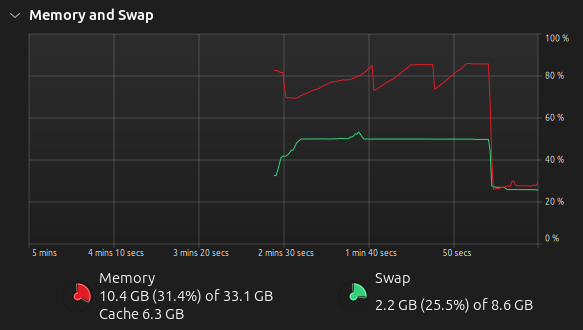

At higher resolution its hard to say where the crash happened but I'm pretty sure the problem arose around here:

```
Making XUGrid ...
Got rid of duplicates in 1.9635 seconds
Made XUGrid in 0.0074 seconds
Removing inactive cells ...
Finding neighbors ...
```

Anyway, at 100 --> 25 m resolution, it took around 1 hour to generate the grid

In [6]:
# %%capture cap 
# "Magic Command" to squash cell output, becuase this stuff tends to print a lot of diagnostics
# Has to be at very top

# SFINCS quadtree build (no subgrid table)
sf = SFINCS(mode="wt", crs=crs)
sf.grid.build(x_min, y_min, nmax, mmax,  dx, dy, rotation,
              refinement_polygons=refinement_polys,
              bathymetry_sets=bathymetry_sets,
              bathymetry_database=bdb)
sf.grid.set_bathymetry(bathymetry_sets, bathymetry_database=bdb)
sf.mask.build(include_polygon=include_poly, open_boundary_polygon=bound_poly)
sf.grid.cut_inactive_cells()

if os.path.exists(quadtree_dir + "sfincs.nc"): 
    os.remove(quadtree_dir + "sfincs.nc")
sf.grid.write(quadtree_dir + "sfincs.nc")

if os.path.exists(quadtree_dir + "sfincs.sbg"): 
    os.remove(quadtree_dir + "sfincs.sbg")
sf.subgrid.build(bathymetry_sets, roughness_sets, file_name=quadtree_dir + "sfincs.sbg",
                 roughness_type="manning", 
                 manning_land=0.04, manning_water=0.020, manning_level=1.0,
                 nr_levels=10, nr_subgrid_pixels=20, huthresh=0.01, 
                 zmin=-20.0, zmax=999999.0, bathymetry_database=bdb)

# Save output of this cell to a file
# with open(quadtree_dir + 'quadtree_build_log.txt', 'w') as file:
#     file.write(cap.stdout)

Building mesh ...
Refining ...
Time elapsed : 28.09896206855774 s
Finding neighbors ...
Time elapsed : 0.11740875244140625 s
Setting neighbors left and below ...
Time elapsed : 0.355968713760376 s
Getting uv points ...
Time elapsed : 0.5326611995697021 s
Making XUGrid ...
Got rid of duplicates in 1.9635 seconds
Made XUGrid in 0.0074 seconds
Removing inactive cells ...
Finding neighbors ...
Time elapsed : 0.048497915267944336 s
Setting neighbors left and below ...
Time elapsed : 0.11298298835754395 s
Getting uv points ...
Time elapsed : 0.23299503326416016 s
Making XUGrid ...
Got rid of duplicates in 0.8006 seconds
Made XUGrid in 0.0070 seconds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Building subgrid tables for SFINCS Quadtree model ...
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Processing level 1 of 3 ...
Number of regular cells in a block : 100
Number of blocks in n direction    : 7
Number of blocks in m direction    : 5
Grid size of flux gri

## Levees

In [11]:
levee_geojson = '/home/cassandra/Snohomish/2025-11/snohomish_levees.geojson'

levee_polygons = gpd.read_file(levee_geojson).set_crs('EPSG:4326').to_crs('EPSG:32610')

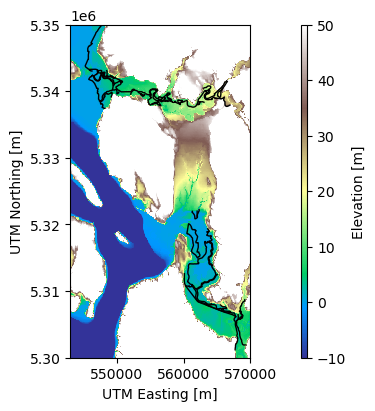

In [27]:
# Load low res DEM for plotting
dem = xr.open_dataset('/home/cassandra/Snohomish/test_data/snohomish_DEM.tif')
lat, lon = dem.y.values, dem.x.values
lala, lolo = np.meshgrid(lat, lon)
xx, yy, _, __ = utm.from_latlon(lala.T, lolo.T)

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
m = plt.pcolormesh(xx, yy, dem.band_data[0], vmin=-10, vmax=50, cmap='terrain')
levee_polygons.plot(ax=ax, linewidth=1, color='black')
cb = plt.colorbar(m, aspect=50, location='right')
cb.ax.set_ylabel("Elevation [m]")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.xlim(543000, 570000)
plt.ylim(5300000, 5350000)
plt.show()

Convert to a SFINCS weir file, sampling the bathymetry, using Maarten's script...

In [28]:
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from shapely.geometry import LineString
import numpy as np

def resample_line(line: LineString, spacing: float) -> list:
    """Return list of equally spaced points along the LineString."""
    distances = np.arange(0, line.length, spacing)
    return [line.interpolate(d) for d in distances]

def extract_elevation(dem_path, levee_gdf, spacing=50.0, radius=10.0, output_txt="levee_profile.txt"):
    # Open the DEM
    with rasterio.open(dem_path) as src:
        pixel_size_x, pixel_size_y = src.res
        pixel_radius = int(np.ceil(radius / max(pixel_size_x, pixel_size_y)))
        # Reproject levee lines to DEM CRS if needed
        if levee_gdf.crs != src.crs:
            levee_gdf = levee_gdf.to_crs(src.crs)
        all_results = []
        for idx, row in levee_gdf.iterrows():
            levee_results = []
            geom = row.geometry
            if geom.is_empty or geom.length == 0:
                continue
            # Resample line at regular spacing
            points = resample_line(geom, spacing)
            for pt in points:
                x, y = pt.x, pt.y
                try:
                    row_idx, col_idx = src.index(x, y)

                    # Define square window around point
                    window = Window(
                        col_off=col_idx - pixel_radius,
                        row_off=row_idx - pixel_radius,
                        width=2 * pixel_radius + 1,
                        height=2 * pixel_radius + 1)
                    # Read data from window
                    data = src.read(1, window=window, boundless=True, fill_value=np.nan)

                    # Build array of distances for masking
                    height, width = data.shape
                    cols, rows = np.meshgrid(
                        np.arange(width), np.arange(height))
                    dx = (cols - width // 2) * pixel_size_x
                    dy = (rows - height // 2) * pixel_size_y
                    distances = np.sqrt(dx**2 + dy**2)

                    # Mask values beyond radius
                    data[distances > radius] = np.nan

                    max_val = np.nanmax(data)

                    levee_results.append((x, y, max_val))
                except Exception as e:
                    print(f"Warning: failed at point ({x:.2f}, {y:.2f}): {e}")
                    continue
            all_results.append(levee_results)
    # Write to ASCII file
    with open(output_txt, "w") as f:
        for ilevee, levee_results in enumerate(all_results):
            if not levee_results:
                continue
            # Write with 4 leading zeros
            f.write(f"levee{ilevee + 1:04d}\n")
            f.write(f"{len(levee_results)} 4\n")
            for x, y, z in levee_results:
                f.write(f"{x:.3f} {y:.3f} {z:.3f} 0.6\n")
    print(f"Written {len(all_results)} levees to: {output_txt}")

extract_elevation(dem_path, levee_polygons, spacing=5, radius=10, output_txt=weir_file)  

Written 50 levees to: /home/cassandra/Snohomish/2025-11/sfincs.weir


## Build SFINCS Runs
### YAML file
I actually only end up using this for the observation points... I ran into errors with the other ones and ended up feeding everything directly. Alas.

In [42]:
yml_str = ''

yml_str = (yml_str + '\n' +
           "tide:" + '\n' + 
           "  " + "path: " + '/home/cassandra/Snohomish/test_data/2025-11-tide.nc' + " \n"
           "  " + "data_type: GeoDataset \n" + 
           "  " + "driver: netcdf \n" + 
           "  " + "crs: 32610 \n")

yml_str = (yml_str + '\n' +
           "discharge:" + '\n' + 
           "  " + "path: " + '/home/cassandra/Snohomish/test_data/2025-11-discharge.nc' + " \n"
           "  " + "data_type: GeoDataset \n" + 
           "  " + "driver: netcdf \n" + 
           "  " + "crs: 32610 \n")

yml_str = (yml_str + '\n' +
           "obs:" + '\n' + 
           "  " + "path: " + '/home/cassandra/Snohomish/test_data/2025-11-obs.geojson' + " \n"
           "  " + "data_type: GeoDataFrame \n" + 
           "  " + "driver: vector \n" + 
           "  " + "crs: 4326 \n")

yaml_path = quadtree_dir + '/hydromt-data-catalog.yml'
with open(yaml_path, mode="w") as f:
    f.write(yml_str)

## HydroMT SFINCS 

In [7]:
year = np.timedelta64(1, 'Y').astype('timedelta64[ms]')
buffer = np.timedelta64(5, 'W').astype('timedelta64[ms]')

tide_t = tide_da.time.values

t0s = np.arange(tide_t[0], tide_t[-1] - year - buffer, year)
tfs = t0s + year + buffer
dt_out = 1800

t0s, tfs = t0s.astype('datetime64[m]'), tfs.astype('datetime64[m]')

In [8]:
t0s, tfs

(array(['1984-09-30T00:00', '1985-09-30T05:49', '1986-09-30T11:38',
        '1987-09-30T17:27', '1988-09-29T23:16', '1989-09-30T05:06',
        '1990-09-30T10:55', '1991-09-30T16:44', '1992-09-29T22:33',
        '1993-09-30T04:22', '1994-09-30T10:12', '1995-09-30T16:01',
        '1996-09-29T21:50', '1997-09-30T03:39', '1998-09-30T09:28',
        '1999-09-30T15:18', '2000-09-29T21:07', '2001-09-30T02:56',
        '2002-09-30T08:45', '2003-09-30T14:34', '2004-09-29T20:24',
        '2005-09-30T02:13', '2006-09-30T08:02', '2007-09-30T13:51',
        '2008-09-29T19:40', '2009-09-30T01:30', '2010-09-30T07:19',
        '2011-09-30T13:08', '2012-09-29T18:57', '2013-09-30T00:46'],
       dtype='datetime64[m]'),
 array(['1985-11-04T05:49', '1986-11-04T11:38', '1987-11-04T17:27',
        '1988-11-03T23:16', '1989-11-04T05:06', '1990-11-04T10:55',
        '1991-11-04T16:44', '1992-11-03T22:33', '1993-11-04T04:22',
        '1994-11-04T10:12', '1995-11-04T16:01', '1996-11-03T21:50',
        '1997-11

In [4]:
discharge_da = xr.open_dataarray('/home/cassandra/Snohomish/test_data/2025-11-discharge.nc')
tide_da = xr.open_dataarray('/home/cassandra/Snohomish/test_data/2025-11-tide.nc')

In [5]:
weir_file = quadtree_dir + "sfincs.weir"
grid_file = quadtree_dir + "sfincs.nc"
subg_file = quadtree_dir + "sfincs.sbg"

In [47]:
# For each year, make model...
for t0, tf in zip(t0s, tfs):
    model_dir = parent_dir + str(t0)[:4] + '/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    print(model_dir)

    # Clear directory if necessary
    for thing in glob.glob(model_dir + 'sfincs.*'):
        os.remove(thing)

    sf = SfincsModel(data_libs=[yaml_path], root=model_dir, mode="w+")
    # Resolution & Extent
    # not important because we're replacing with quadtree
    dg = 25000
    x_min, x_max = 540000, 590000
    y_min, y_max = 5285000, 5350000
    x_extent = x_max - x_min
    y_extent = y_max - y_min
    tstart = str(t0)[:10].replace('-', '') + ' ' + str(t0)[11:].replace(':', '')
    tstop  = str(tf)[:10].replace('-', '') + ' ' + str(tf)[11:].replace(':', '')
    dt_out = 1800
    
    # Generate SFINCS stuff
    sf.setup_grid(x0=x_min, y0=y_min, dx=dg, dy=dg, 
                  nmax=int(y_extent/dg)+1, mmax=int(x_extent/dg)+1, 
                  rotation=0, epsg=32610)
    sf.setup_config(**{"tref": tstart, "tstart": tstart,  "tstop": tstop,
                       "dtout": str(dt_out), "storevel": "1"})
    sf.set_forcing(tide_da,      name='bzs')
    sf.set_forcing(discharge_da, name='dis')
    sf.setup_observation_points(locations='obs')
    # Save model input
    sf.write()

    # Copy over quadtree files
    copy_files = [grid_file, subg_file, weir_file]
    for file_path in copy_files:
        file_name = file_path.split('/')[-1]
        target_destination = model_dir + file_name
        if os.path.exists(target_destination):
            os.remove(target_destination)
        shutil.copyfile(file_path, target_destination)
    
    # Create sfincs.inp from template
    template_path = "/home/cassandra/Snohomish/TEMPLATE_weirs_sfincs.inp"
    input_template_file = open(template_path, 'r')
    input_template = input_template_file.read()
    input_file_content = input_template.format(TSTART=tstart, TSTOP=tstop, TREF=tstart, DTOUT=str(dt_out))
    if os.path.exists(model_dir + 'sfincs.inp'):
        os.remove(model_dir + 'sfincs.inp')
    input_file = open(model_dir + 'sfincs.inp', "w")
    input_file.write(input_file_content)
    input_file.close()

/home/cassandra/Snohomish/2025-11/snohomish_30/1984/
/home/cassandra/Snohomish/2025-11/snohomish_30/1985/
/home/cassandra/Snohomish/2025-11/snohomish_30/1986/
/home/cassandra/Snohomish/2025-11/snohomish_30/1987/
/home/cassandra/Snohomish/2025-11/snohomish_30/1988/
/home/cassandra/Snohomish/2025-11/snohomish_30/1989/
/home/cassandra/Snohomish/2025-11/snohomish_30/1990/
/home/cassandra/Snohomish/2025-11/snohomish_30/1991/
/home/cassandra/Snohomish/2025-11/snohomish_30/1992/
/home/cassandra/Snohomish/2025-11/snohomish_30/1993/
/home/cassandra/Snohomish/2025-11/snohomish_30/1994/
/home/cassandra/Snohomish/2025-11/snohomish_30/1995/
/home/cassandra/Snohomish/2025-11/snohomish_30/1996/
/home/cassandra/Snohomish/2025-11/snohomish_30/1997/
/home/cassandra/Snohomish/2025-11/snohomish_30/1998/
/home/cassandra/Snohomish/2025-11/snohomish_30/1999/
/home/cassandra/Snohomish/2025-11/snohomish_30/2000/
/home/cassandra/Snohomish/2025-11/snohomish_30/2001/
/home/cassandra/Snohomish/2025-11/snohomish_30

In [9]:
import os

slurm_template = """#!/bin/bash

#SBATCH -J {foldername}
#SBATCH -A coastallab
#SBATCH -p cpu-g2
#SBATCH -c 96
#SBATCH -t 24:00:00
#SBATCH -v
#SBATCH -o /gscratch/coastallab/cshender/{foldername}/%x_%j.out

cd /gscratch/coastallab/cshender/{foldername}/
module load singularity
singularity run -B$(pwd) /gscratch/coastallab/cshender/sfincs-cpu.img
"""

slurm_dir = parent_dir + 'slurm/'
if not os.path.exists(slurm_dir):
    os.mkdir(slurm_dir)

for t0, tf in zip(t0s, tfs):
    model_dir = parent_dir + str(t0)[:4] + '/'
    foldername = 'snohomish_30/' + str(t0)[:4] 
    with open(slurm_dir + 'snohomish_30_' + str(t0)[:4]  + '.sh', 'w') as f:
        f.write(slurm_template.format(foldername=foldername))